In [19]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from matplotlib.lines import Line2D


np.random.seed(0)

# Creating the Dataset

In [20]:
def create_data(points, classes): # Creates a dataset of spiral shaped clusters
    X = np.zeros((points * classes, 2))
    y = np.zeros(points * classes, dtype='uint8')

    for class_number in range(classes):
        ix = range(points * class_number,
                   points * (class_number + 1))
        r = np.linspace(0.0, 1, points)  # radius
        t = np.linspace(class_number * 4,
                        (class_number + 1) * 4,
                        points) + np.random.randn(points) * 0.2
        X[ix] = np.c_[r * np.sin(t * 2.5),
                      r * np.cos(t * 2.5)]
        y[ix] = class_number

    # Remove points where |x| < 0.1 AND |y| < 0.1
    mask = ~((np.abs(X[:, 0]) < 0.1) & (np.abs(X[:, 1]) < 0.1))
    X = X[mask]
    y = y[mask]

    return X, y

X,Y = create_data(300,3)

# Layers

In [21]:
class Neuron_Layer():
    def __init__(self, n_inputs,n_neurons):
        self.weights = 0.1*np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1,n_neurons))
        pass

    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights)+self.biases
        pass
    
    def backward(self,dvalues):
        # Biases are constants so do not have an effect on dweights
        self.dweights = np.dot(self.inputs.T, dvalues) # f(a,b) = a*b => f`a(a,b) = b
        # # f(a,b) = a + b => f`b(a,b) = 1, accumulate gradient from all samples
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

# Activation Functions

In [22]:
class Activation_ReLU():
    def forward(self,inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
        
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [23]:
class Activation_Softmax():
    def forward(self,inputs):
        exps = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
        normalised = exps / np.sum(exps,axis=1,keepdims=True)
        self.output = normalised
    
    def backward(self,dvalues): 
        # TODO Reread 216-225
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output,single_dvalues) in enumerate(zip(self.output,dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
                              
            # Calculate sample-wise gradient.
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

# Optimizers

In [24]:
class Optimizer_SGD:
    def __init__(self,learning_rate=1.0, decay=0., momentum=0.):
        self.learning_rate=learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self,layer : Neuron_Layer):
        # Momentum helps to not get stuck in a local minimum
        if self.momentum:
            if not hasattr(layer,"weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    def post_update_params(self):
        self.iterations += 1

# Loss

In [25]:
class Loss:
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [26]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)
        
        if len(y_true.shape)==1: # Labels are class indicies
            correct_confidences = y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape)==2: # One hot encoding
            correct_confidences = np.sum(y_pred_clipped*y_true,axis=1)
        
        loss = -np.log(correct_confidences)
        return loss
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape)==1:
            # If it is sparse, convert to one-hot
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true/dvalues # Calculate gradient
        self.dinputs = self.dinputs/samples # Normalize gradient

Below is a combined implementation of the softmax activation function and the Categorical Crossentropy loss function, which is more optimal.

In [27]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output,y_true)
    
    def backward(self,dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape)==2: # If one hot, turn it into sparse (discrete)
            y_true = np.argmax(y_true,axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -=1
        self.dinputs = self.dinputs / samples 

# Spiral dataset
In the below cells I will attempt to create and train a neural network on the spiral dataset created in cell 2.

In [28]:
# Defining the structure of the network


layer1 = Neuron_Layer(2,64)
activation1 = Activation_ReLU()

layer2 = Neuron_Layer(64,64) # Hidden layer
activation2 =Activation_ReLU()

layer3 = Neuron_Layer(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD(learning_rate=0.75,decay=0.0001,momentum=0.5)

In [29]:
# Forward pass
layer1.forward(X)
activation1.forward(layer1.output)

layer2.forward(activation1.output)
activation2.forward(layer2.output)

layer3.forward(activation2.output)
loss = loss_activation.forward(layer3.output, Y)

predictions = np.argmax(loss_activation.output,axis=1)
y = Y.copy()
if len(y.shape) == 2:
    y = np.argmax(Y, axis=1)
accuracy = np.mean(predictions==y)
print('loss:', loss)
print('acc:', accuracy)



loss: 1.097941609891182
acc: 0.3937106918238994




## Backward Pass: Softmax + Categorical Crossentropy

The backward pass through the **softmax** and **categorical crossentropy loss** can be implemented in two different ways.

---

### **Combined Implementation (Recommended)**

This approach fuses the softmax activation and categorical crossentropy loss into a single backward pass.
It is **computationally more efficient** and **numerically stable**.

```python
softmax_loss = Activation_Softmax_Loss_CategoricalCrossentropy()
softmax_loss.backward(activation2.output, Y)
dvalues1 = softmax_loss.dinputs
```

---

### **Separate Implementation (Less Optimal)**

This approach computes the backward pass for the loss and activation **independently**, resulting in extra computation.

```python
activation = Activation_Softmax()
activation.output = activation2.output

loss = Loss_CategoricalCrossentropy()
loss.backward(activation2.output, Y)

activation.backward(loss.dinputs)
dvalues2 = activation.dinputs
```



In [30]:
loss_activation.backward(loss_activation.output, Y)
layer3.backward(loss_activation.dinputs)
activation2.backward(layer3.dinputs)
layer2.backward(activation2.dinputs)
activation1.backward(layer2.dinputs)
layer1.backward(activation1.dinputs)


print(layer1.dweights)
print(layer1.dbiases)
print(layer2.dweights)
print(layer2.dbiases)
print(layer3.dweights)
print(layer3.dbiases)


optimizer.update_params(layer1)
optimizer.update_params(layer2)
optimizer.update_params(layer3)


[[-2.96319972e-04 -3.04595026e-04 -2.59228804e-04 -6.90420515e-04
  -4.07687420e-04  1.29660217e-03 -4.45870116e-04 -5.02503441e-04
   3.87738698e-04  3.95385795e-04 -5.92235355e-05 -5.47096728e-04
   4.99474955e-05 -3.46796144e-04 -4.09331001e-04  6.23141871e-04
  -9.50301580e-04 -6.40825110e-04  1.40477449e-03  1.35552905e-03
   2.27145096e-04  1.01843762e-03 -7.20461729e-05  6.36318583e-04
  -4.69232469e-04  6.95130857e-04 -5.48302439e-04 -7.80645039e-05
  -2.10373614e-03  6.42042882e-04 -1.70484249e-04 -3.25056217e-04
  -7.63740686e-04  2.71561891e-04  4.08213917e-04 -3.68312978e-04
   9.85869816e-04  1.42853892e-03  1.03068927e-03 -1.47422244e-03
   7.00732142e-04 -2.24188902e-04  1.01853501e-03  2.01774793e-03
   1.03293852e-03 -8.99448208e-04 -5.85820436e-04 -6.76297265e-04
   1.55493594e-03  2.80397194e-04  2.01905989e-03 -4.93687710e-04
  -4.52916228e-04  2.50402187e-04  9.25758776e-04  4.54720094e-05
  -5.71830435e-04  1.21060790e-04 -2.85049239e-04  1.37750076e-03
   3.94371

# Learning with the SGD optimizer

In [31]:
b_layer1 = copy.copy(layer1)
b_layer2 = copy.copy(layer2)
b_layer3 = copy.copy(layer3)
b_activation1 = copy.copy(activation1)
b_activation2 = copy.copy(activation2)
b_loss_activation = copy.copy(loss_activation)
b_acc = 0
for epoch in range(15001):
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    loss = loss_activation.forward(layer3.output, Y)
    predictions = np.argmax(loss_activation.output,axis=1)
    accuracy = np.mean(predictions==Y)

    if epoch%500==0:
        print(f"Epoch: {epoch} | acc: {accuracy:.3f} | loss: {loss:.3f}")
    
    loss_activation.backward(loss_activation.output, Y)
    layer3.backward(loss_activation.dinputs)
    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    if accuracy>b_acc:
        b_layer1 = copy.copy(layer1)
        b_layer2 = copy.copy(layer2)
        b_layer3 = copy.copy(layer3)
        b_activation1 = copy.copy(activation1)
        b_activation2 = copy.copy(activation2)
        b_loss_activation = copy.copy(loss_activation)
        b_acc = accuracy
    
    optimizer.pre_update_params()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.update_params(layer3)
    optimizer.post_update_params()

Epoch: 0 | acc: 0.411 | loss: 1.097
Epoch: 500 | acc: 0.872 | loss: 0.367
Epoch: 1000 | acc: 0.917 | loss: 0.198
Epoch: 1500 | acc: 0.918 | loss: 0.173
Epoch: 2000 | acc: 0.923 | loss: 0.171
Epoch: 2500 | acc: 0.932 | loss: 0.153
Epoch: 3000 | acc: 0.926 | loss: 0.150
Epoch: 3500 | acc: 0.930 | loss: 0.140
Epoch: 4000 | acc: 0.914 | loss: 0.176
Epoch: 4500 | acc: 0.931 | loss: 0.144
Epoch: 5000 | acc: 0.933 | loss: 0.144
Epoch: 5500 | acc: 0.943 | loss: 0.124
Epoch: 6000 | acc: 0.935 | loss: 0.137
Epoch: 6500 | acc: 0.938 | loss: 0.131
Epoch: 7000 | acc: 0.943 | loss: 0.131
Epoch: 7500 | acc: 0.946 | loss: 0.121
Epoch: 8000 | acc: 0.956 | loss: 0.102
Epoch: 8500 | acc: 0.955 | loss: 0.104
Epoch: 9000 | acc: 0.938 | loss: 0.131
Epoch: 9500 | acc: 0.955 | loss: 0.099
Epoch: 10000 | acc: 0.942 | loss: 0.115
Epoch: 10500 | acc: 0.952 | loss: 0.109
Epoch: 11000 | acc: 0.943 | loss: 0.117
Epoch: 11500 | acc: 0.957 | loss: 0.090
Epoch: 12000 | acc: 0.955 | loss: 0.100
Epoch: 12500 | acc: 0.92

Epoch: Validation | acc: 0.956 | loss: 0.102


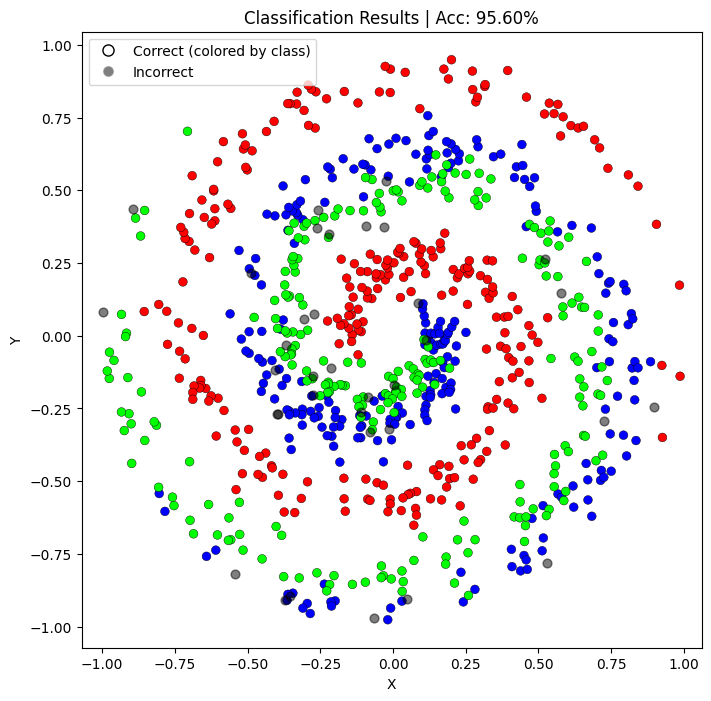

In [32]:
X,Y = create_data(300,3)
b_layer1.forward(X)
b_activation1.forward(layer1.output)
b_layer2.forward(activation1.output)
b_activation2.forward(layer2.output)
b_layer3.forward(activation2.output)
loss = b_loss_activation.forward(b_layer3.output, Y)
predictions = np.argmax(b_loss_activation.output,axis=1)
accuracy = np.mean(predictions==Y)
print(f"Epoch: Validation | acc: {accuracy:.3f} | loss: {loss:.3f}")
correct = predictions == Y
incorrect = ~correct

plt.figure(figsize=(8, 8))

# Correct classifications (colored by class)
plt.scatter(
    X[correct, 0],
    X[correct, 1],
    c=Y[correct],
    cmap='brg',
    s=40,
    edgecolors='k',
    linewidths=0.3
)

# Incorrect classifications (black, semi-transparent)
plt.scatter(
    X[incorrect, 0],
    X[incorrect, 1],
    c='black',
    alpha=0.5,
    s=40
)

# Custom legend (fixes color mismatch)
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='white', markeredgecolor='black',
           markersize=8, label='Correct (colored by class)'),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='black', alpha=0.5,
           markersize=8, label='Incorrect')
]

plt.legend(handles=legend_elements)

plt.title(f"Classification Results | Acc: {accuracy*100:.2f}%")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.savefig("./demo/spiralClassification.png", dpi=300, bbox_inches="tight")
plt.show()